In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 1. Import libraries and data

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Load Data
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


# 2. Data Exploration

In [3]:
# Display Basic Information
print(train_data.info())
print(test_data.info())

# Check for Missing Values
missing_train = (train_data.isnull().sum() / len(train_data)) * 100
missing_test = (test_data.isnull().sum() / len(test_data)) * 100
print("Missing values in train data:\n", missing_train[missing_train > 0].sort_values(ascending=False))
print("Missing values in test data:\n", missing_test[missing_test > 0].sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 3. Data cleaning

In [4]:
# Drop unnecessary columns
drop_cols = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
X_train = train_data.drop(columns=drop_cols + ['SalePrice'])
y_train = train_data['SalePrice']
X_test = test_data.drop(columns=drop_cols)

# Impute missing values
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])


# 4. features Extraction

In [5]:
# Feature Engineering
X_train['AgeOfHouse'] = X_train['YrSold'] - X_train['YearBuilt']
X_test['AgeOfHouse'] = X_test['YrSold'] - X_test['YearBuilt']

X_train['TotalBsmtArea'] = X_train['BsmtFinSF1'] + X_train['BsmtFinSF2'] + X_train['BsmtUnfSF']
X_test['TotalBsmtArea'] = X_test['BsmtFinSF1'] + X_test['BsmtFinSF2'] + X_test['BsmtUnfSF']

X_train['RoomsPerSqft'] = X_train['TotRmsAbvGrd'] / X_train['GrLivArea']
X_test['RoomsPerSqft'] = X_test['TotRmsAbvGrd'] / X_test['GrLivArea']


# 5. Data Visualization

   - train data

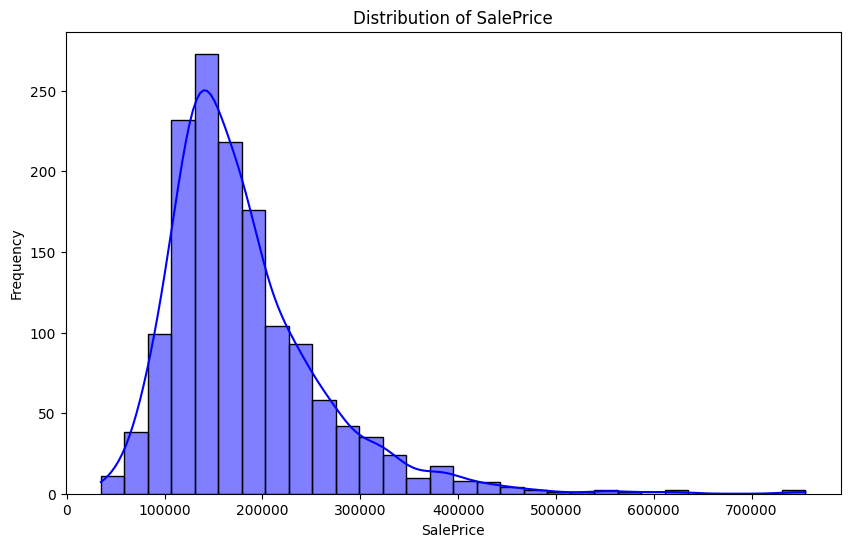

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='blue')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

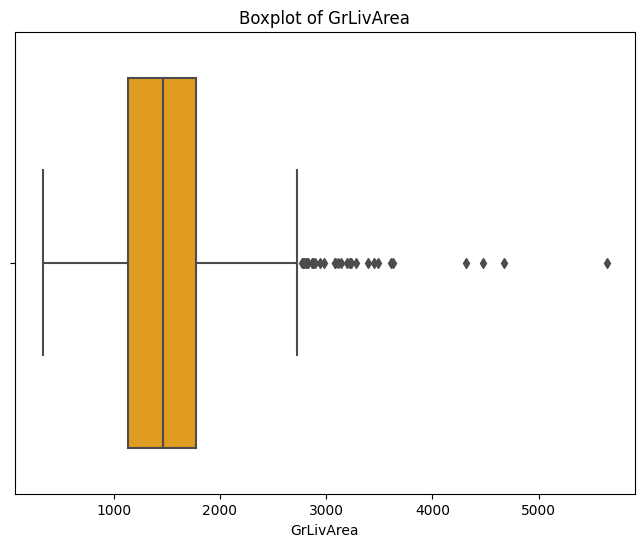

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['GrLivArea'], color='orange')
plt.title("Boxplot of GrLivArea")
plt.xlabel("GrLivArea")
plt.show()

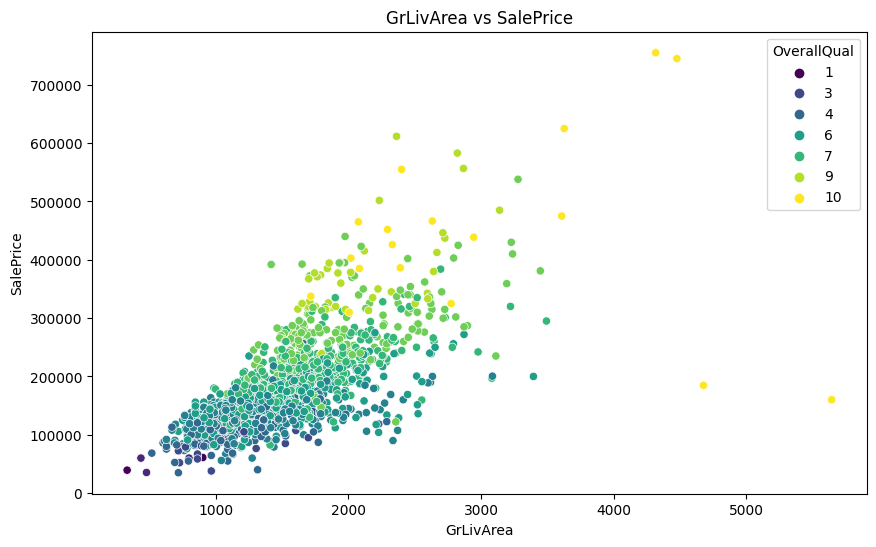

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], hue=train_data['OverallQual'], palette="viridis")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

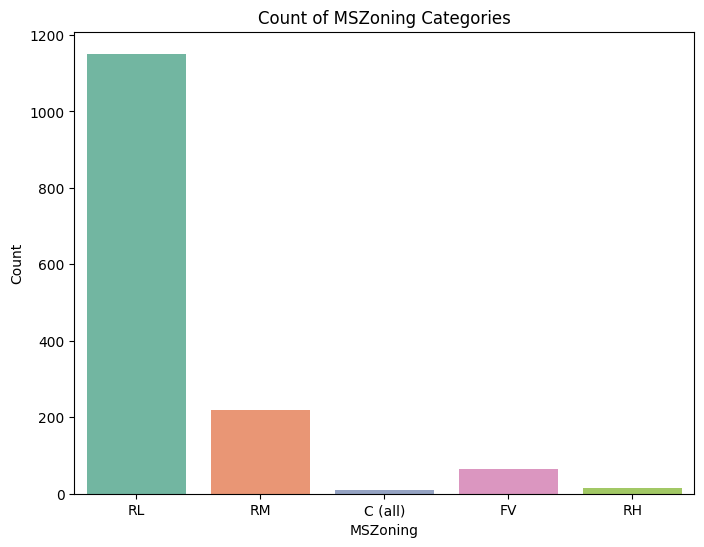

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='MSZoning', data=train_data, palette='Set2')
plt.title("Count of MSZoning Categories")
plt.xlabel("MSZoning")
plt.ylabel("Count")
plt.show()

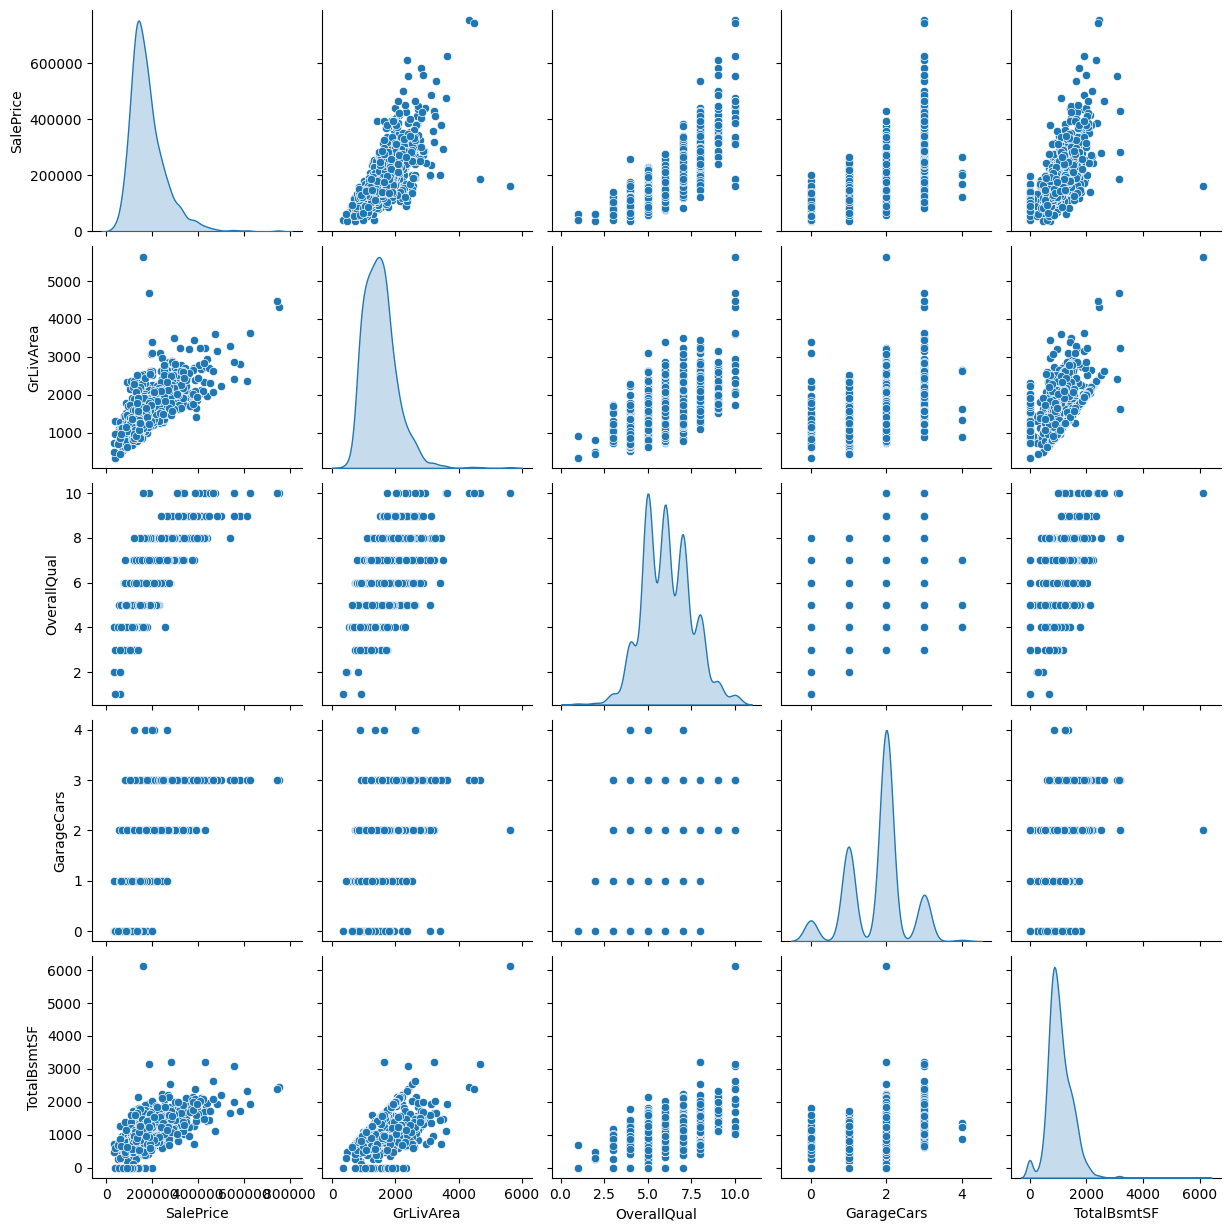

In [10]:
selected_columns = ['SalePrice', 'GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(train_data[selected_columns], diag_kind="kde", kind="scatter", palette="husl")
plt.show()

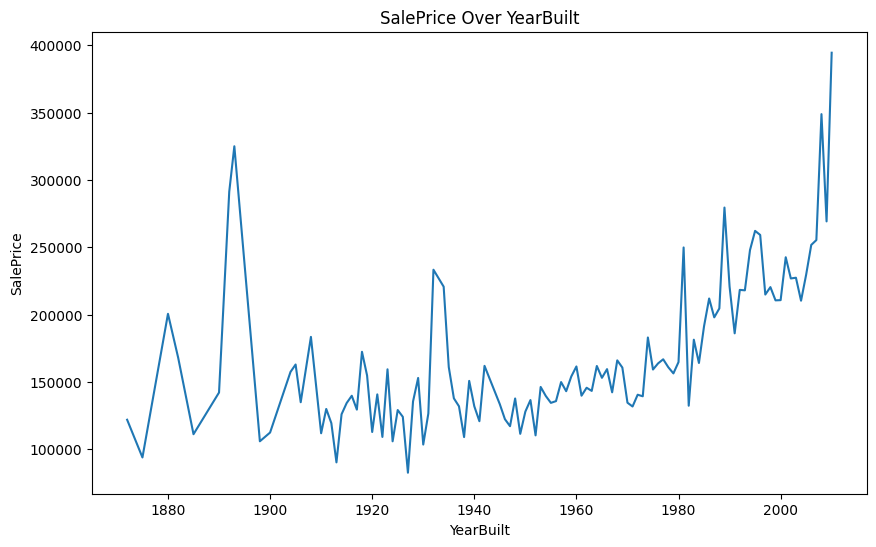

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_data, ci=None)
plt.title("SalePrice Over YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice")
plt.show()

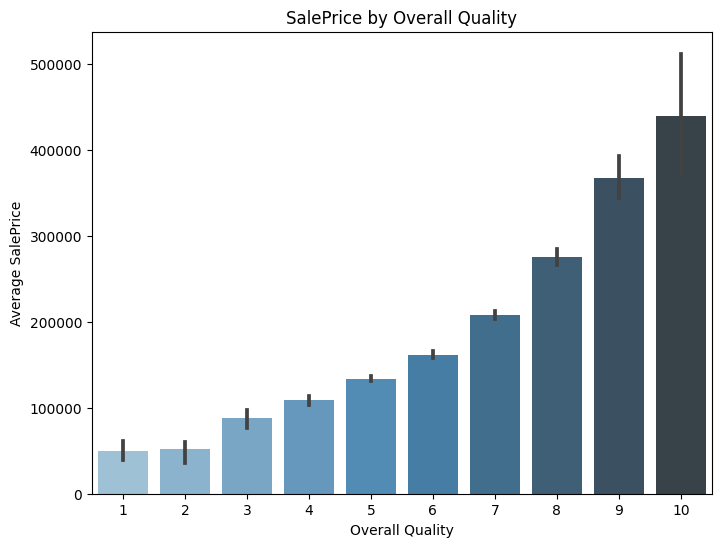

In [12]:
plt.figure(figsize=(8, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=train_data, palette="Blues_d")
plt.title("SalePrice by Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Average SalePrice")
plt.show()

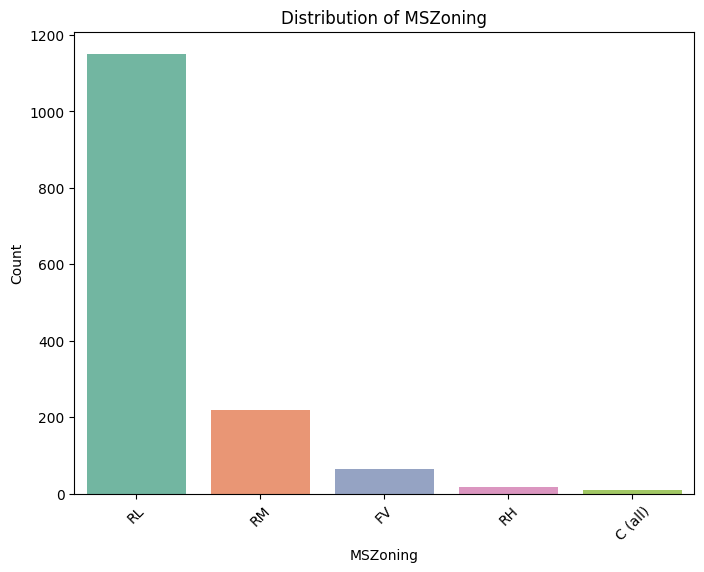

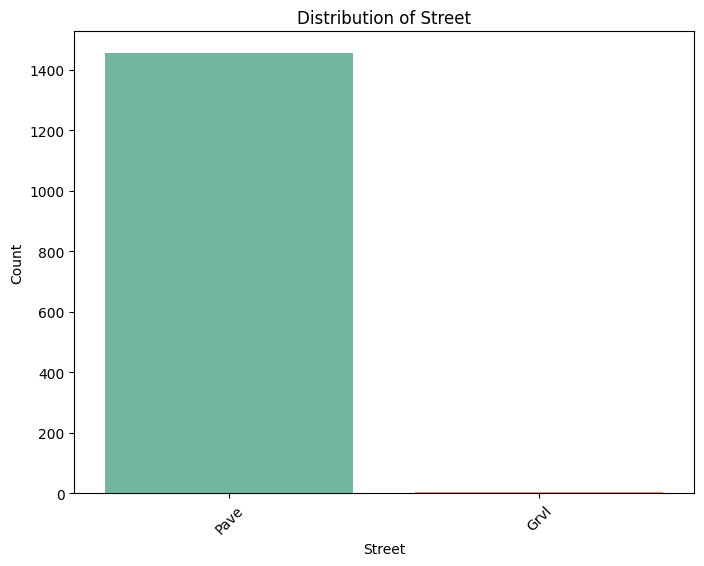

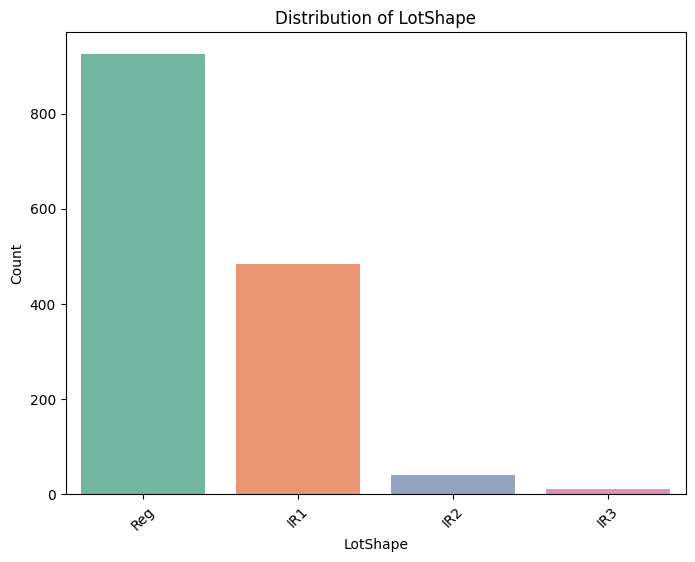

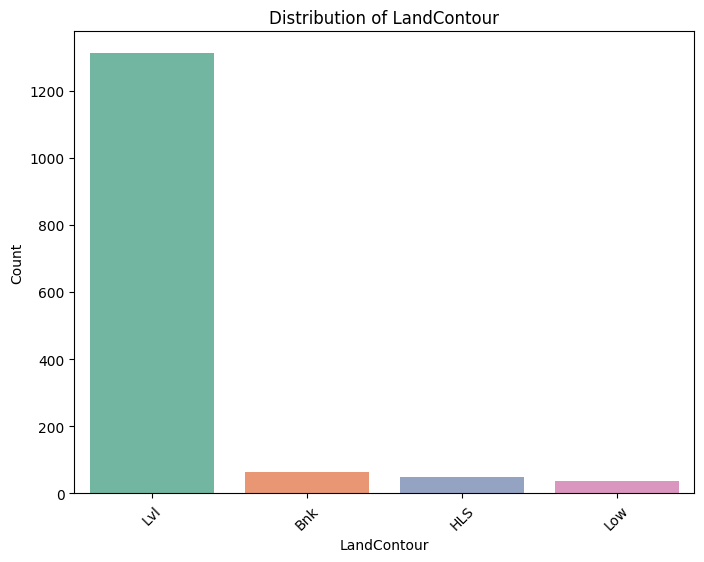

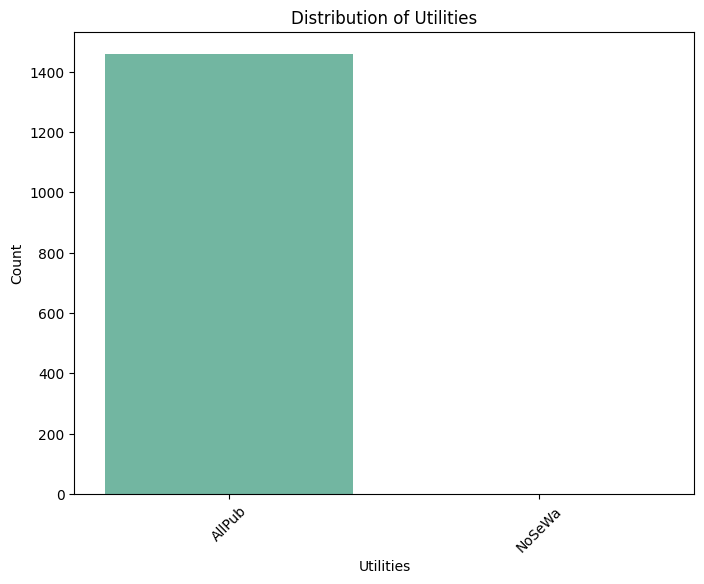

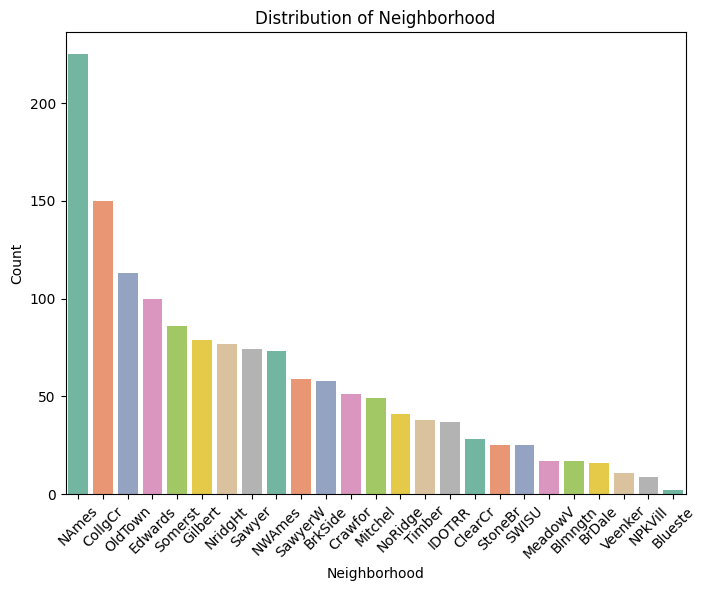

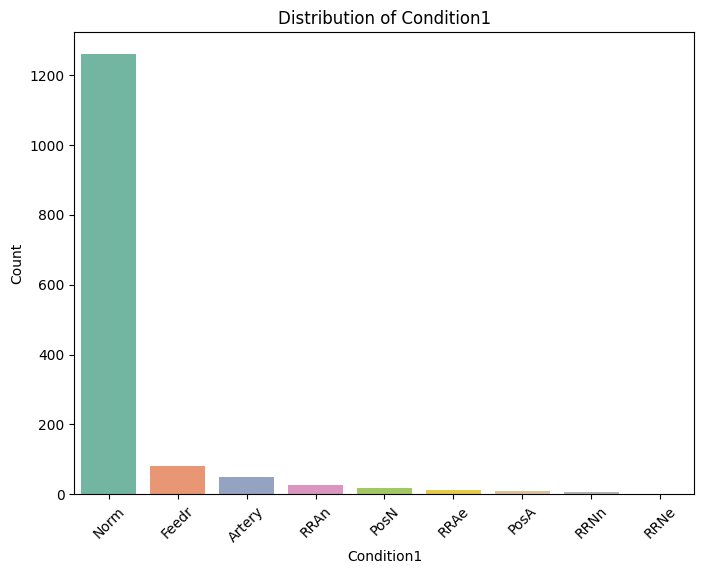

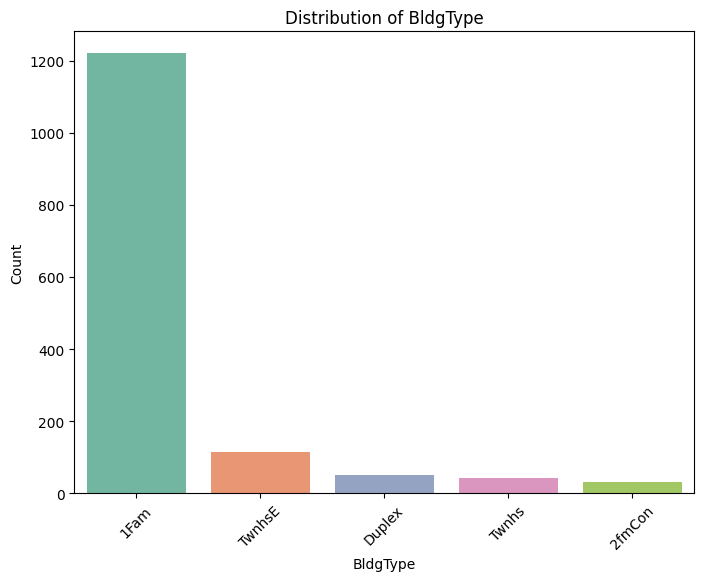

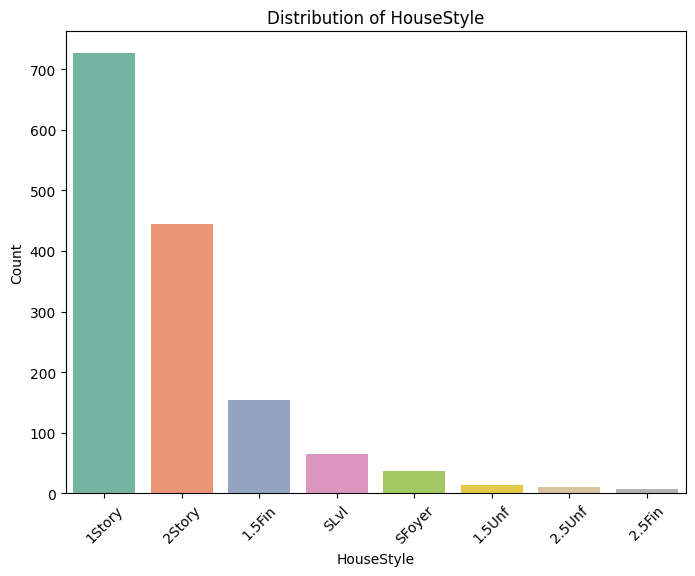

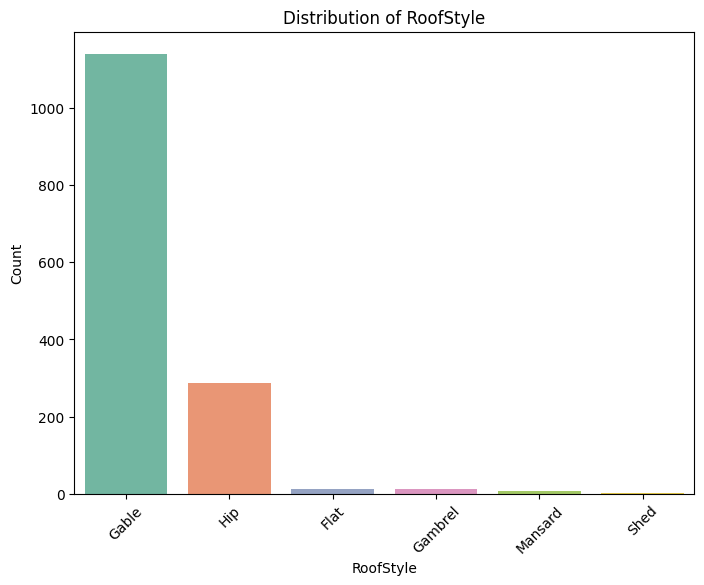

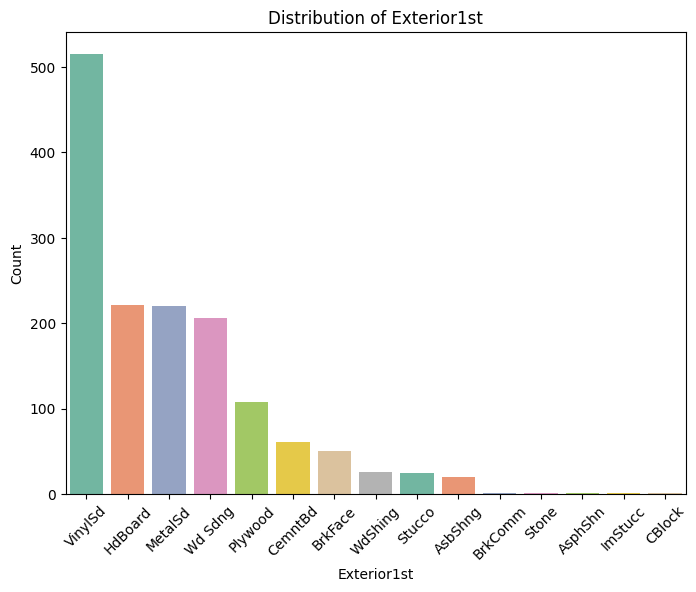

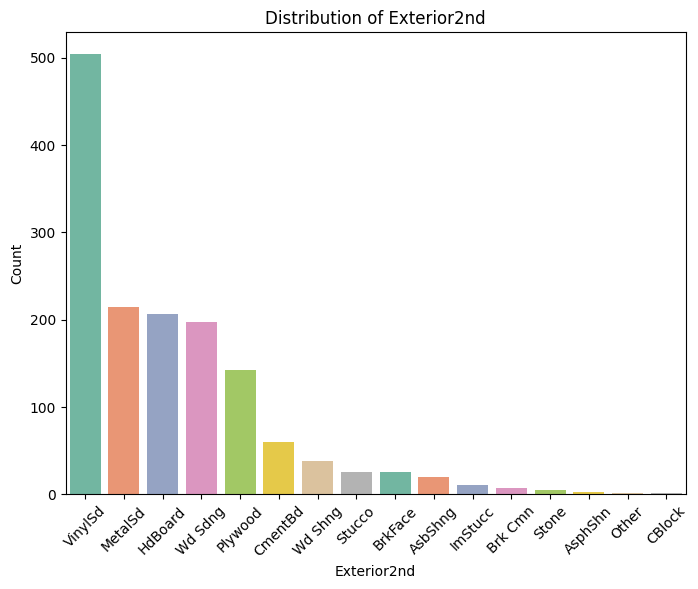

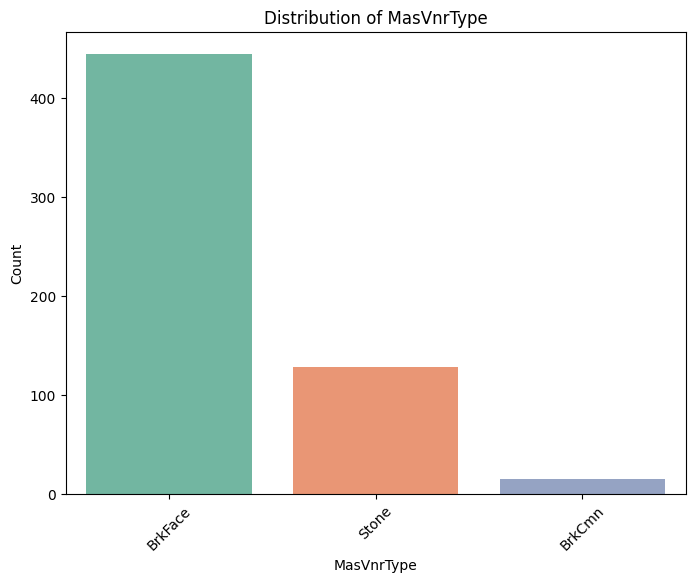

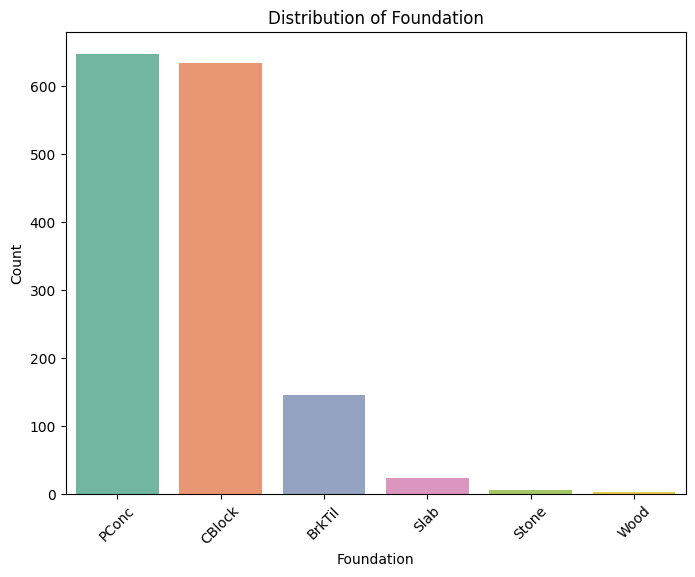

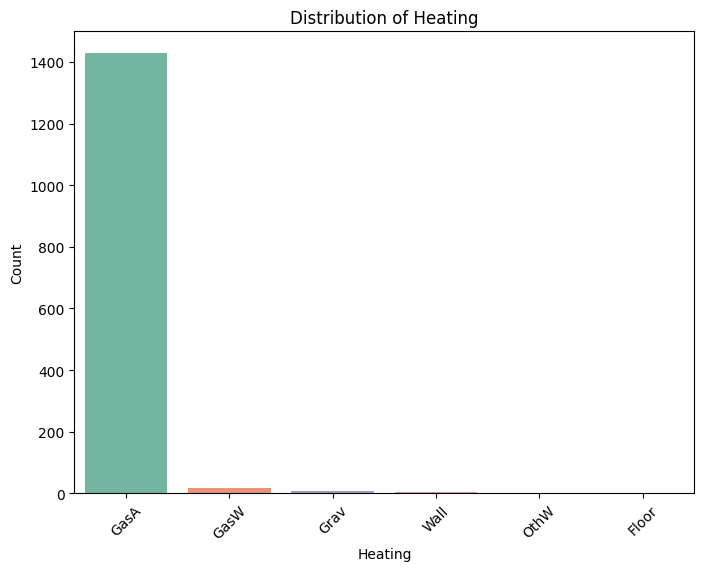

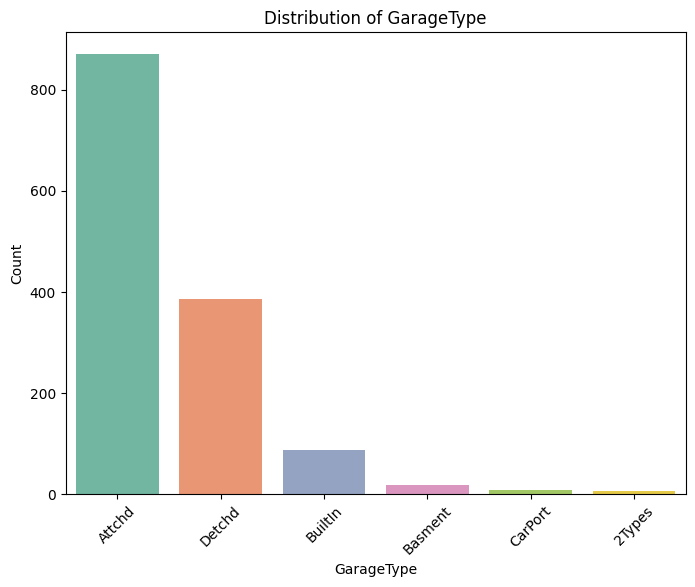

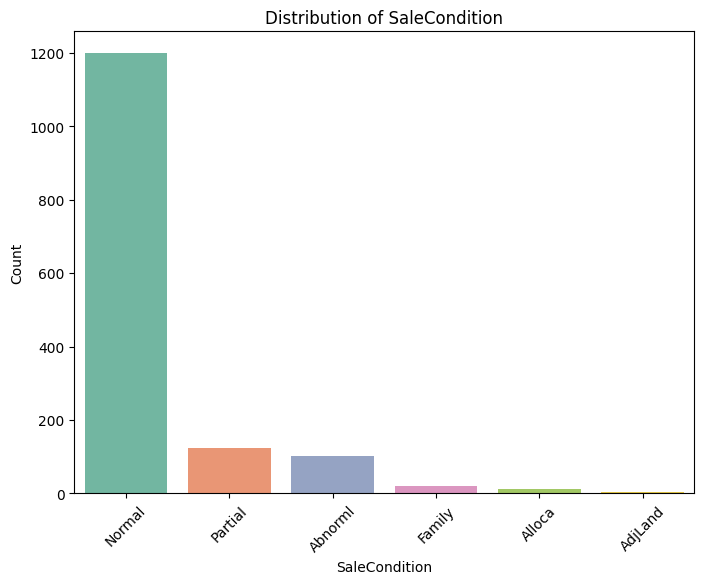

In [13]:



categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
                       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                       'Foundation', 'Heating', 'GarageType', 'SaleCondition']

# Loop through categorical columns and visualize the distribution
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    if col in train_data.columns:  # تحقق من وجود العمود
        sns.countplot(x=train_data[col], order=train_data[col].value_counts().index, palette="Set2")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column {col} is not in the DataFrame.")

   - test data

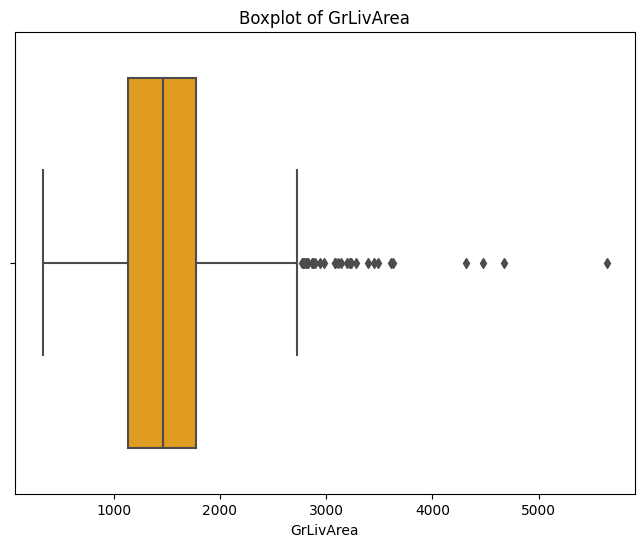

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['GrLivArea'], color='orange')
plt.title("Boxplot of GrLivArea")
plt.xlabel("GrLivArea")
plt.show()





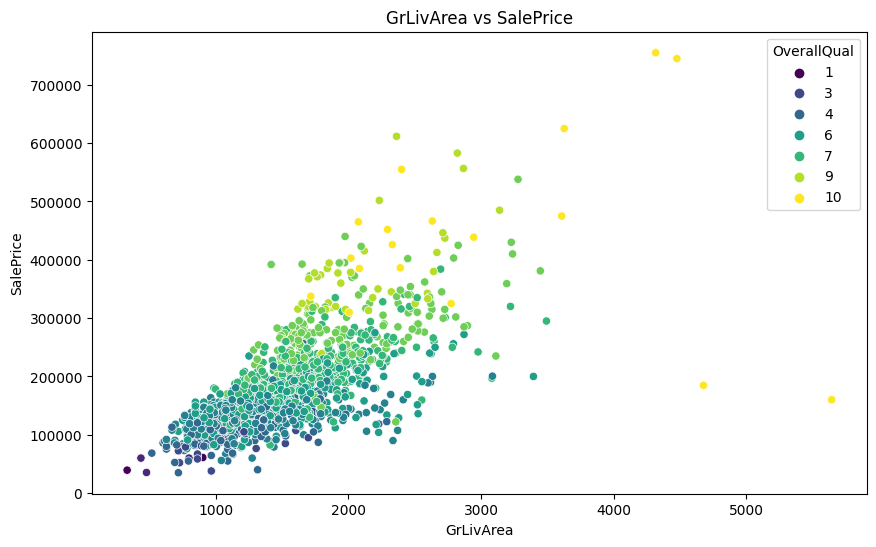

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], hue=train_data['OverallQual'], palette="viridis")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()



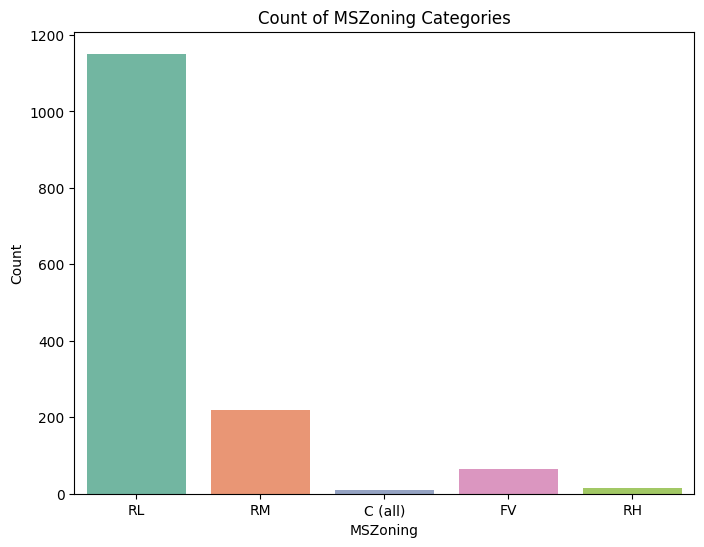

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='MSZoning', data=train_data, palette='Set2')
plt.title("Count of MSZoning Categories")
plt.xlabel("MSZoning")
plt.ylabel("Count")
plt.show()

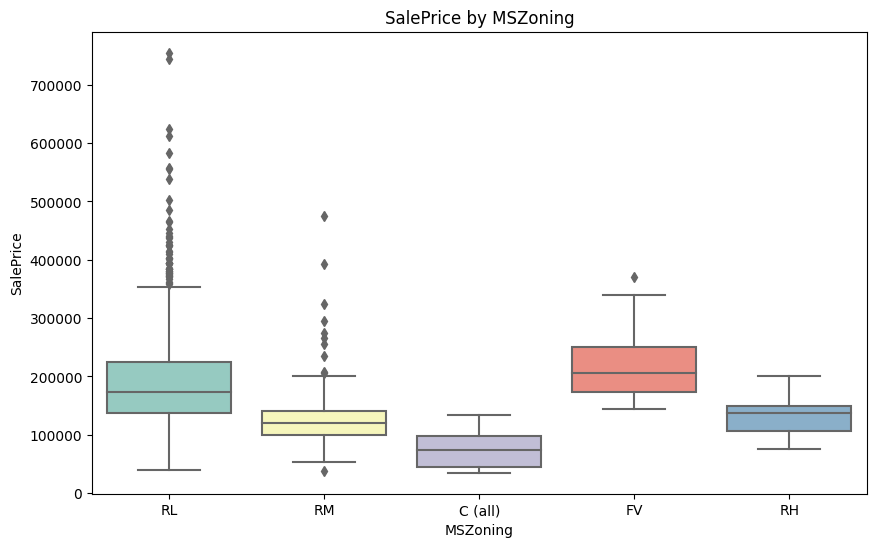

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MSZoning', y='SalePrice', data=train_data, palette='Set3')
plt.title("SalePrice by MSZoning")
plt.xlabel("MSZoning")
plt.ylabel("SalePrice")
plt.show()



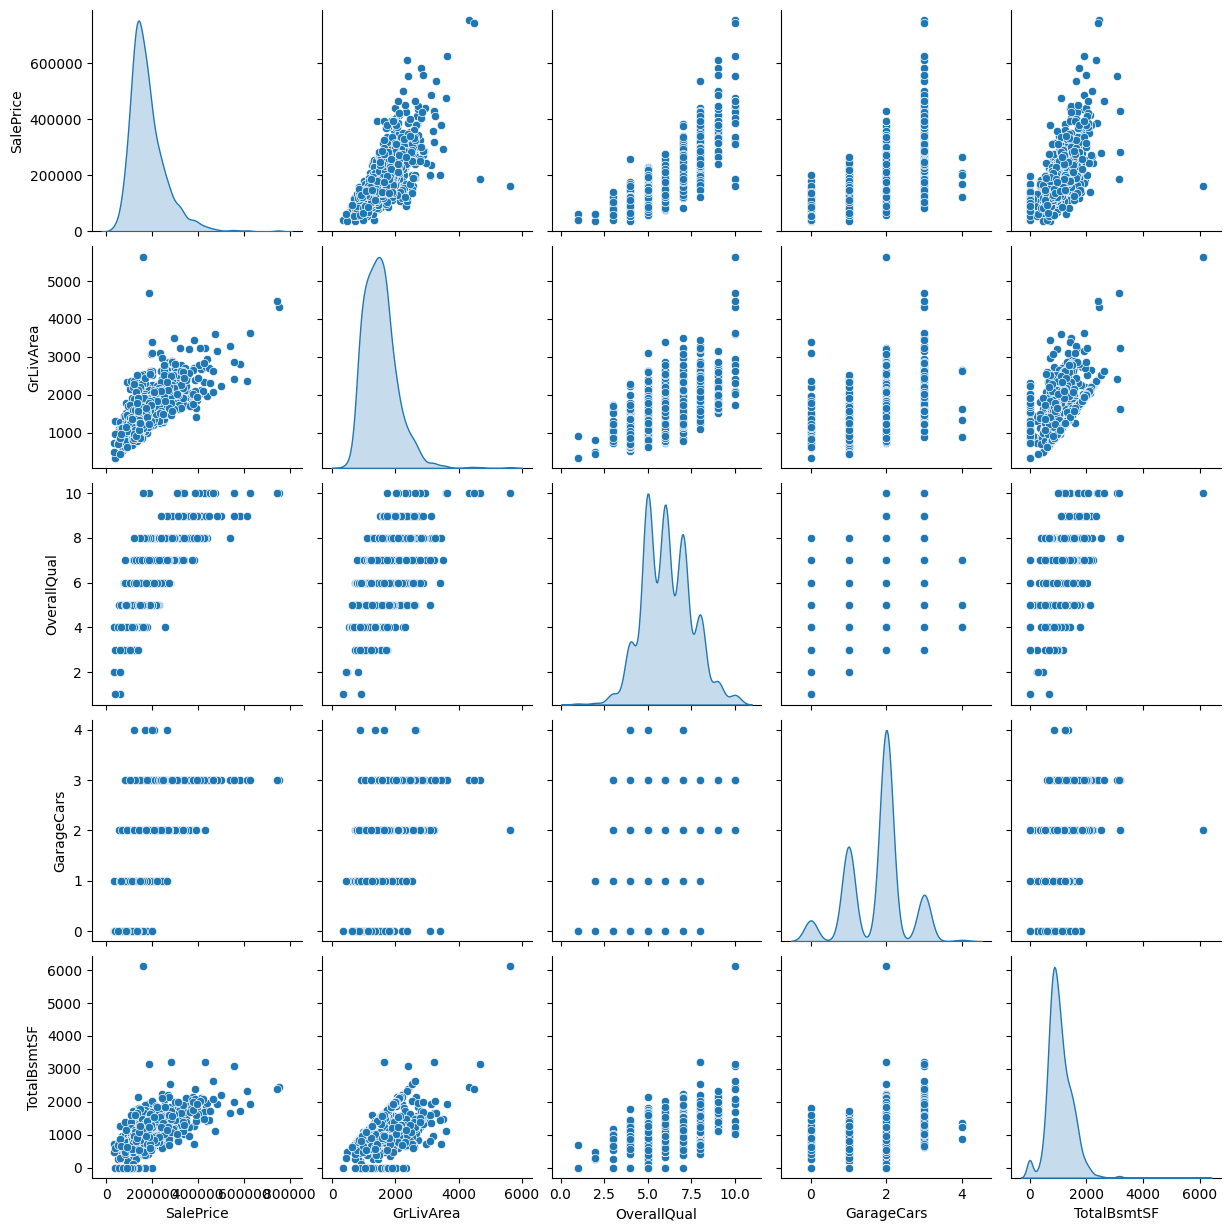

In [18]:
selected_columns = ['SalePrice', 'GrLivArea', 'OverallQual', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(train_data[selected_columns], diag_kind="kde", kind="scatter", palette="husl")
plt.show()

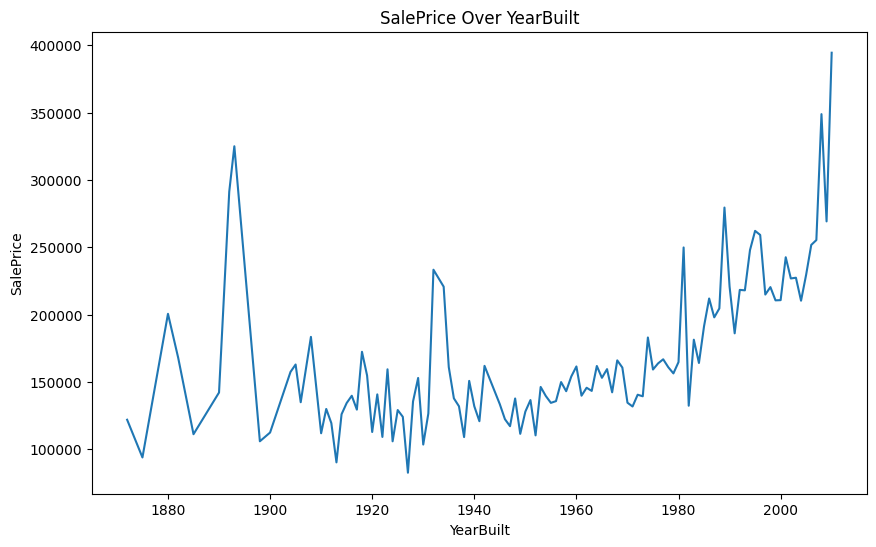

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_data, ci=None)
plt.title("SalePrice Over YearBuilt")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice")
plt.show()

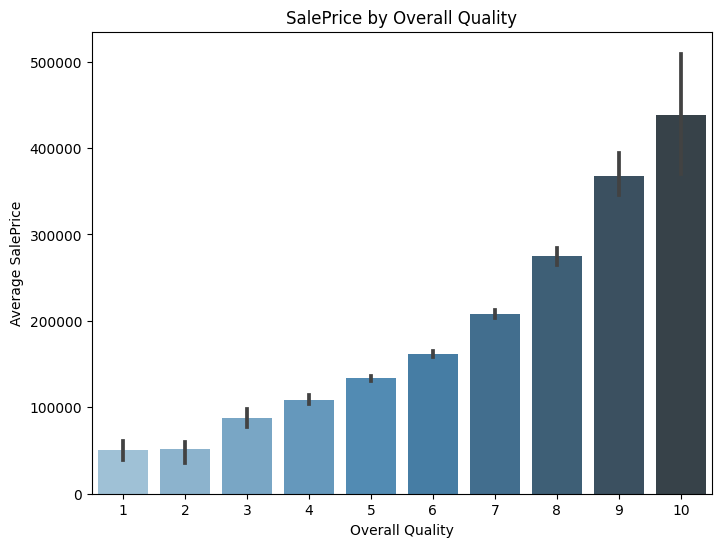

In [20]:
plt.figure(figsize=(8, 6))
sns.barplot(x='OverallQual', y='SalePrice', data=train_data, palette="Blues_d")
plt.title("SalePrice by Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Average SalePrice")
plt.show()



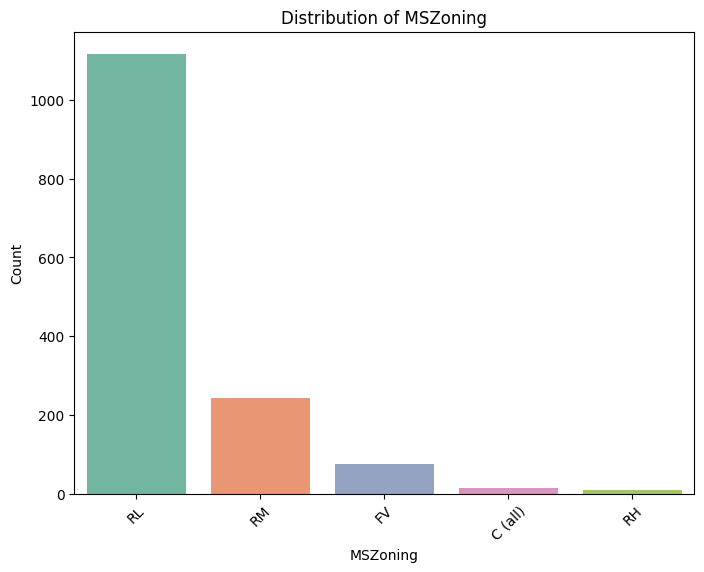

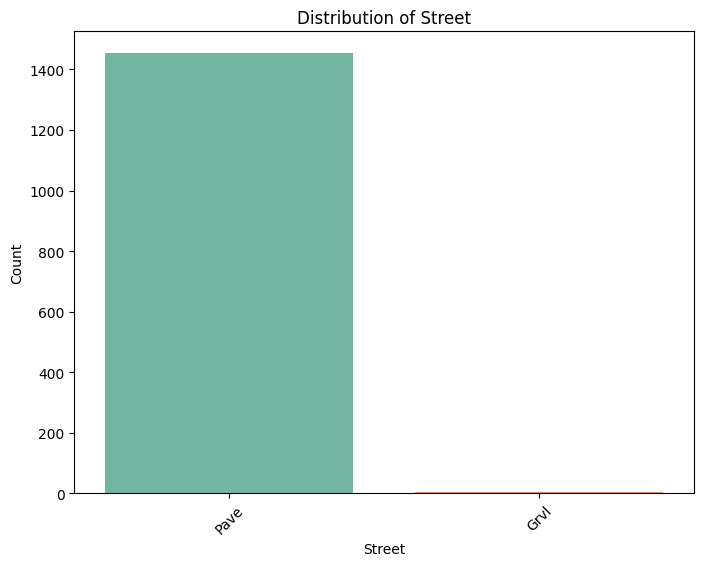

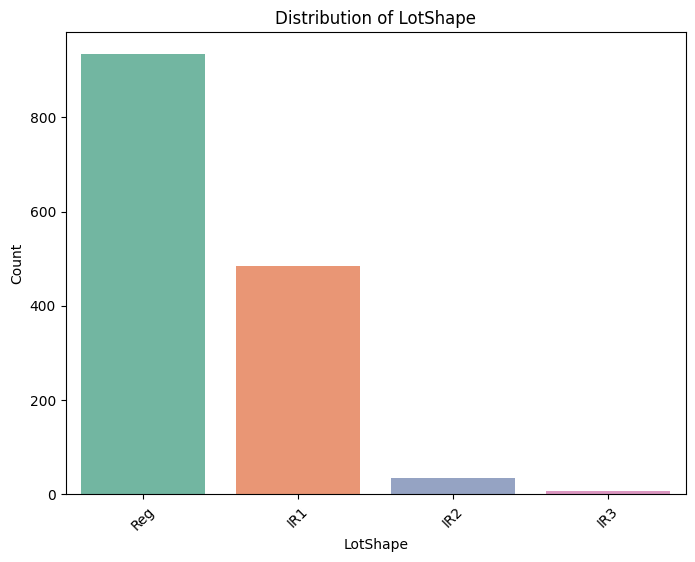

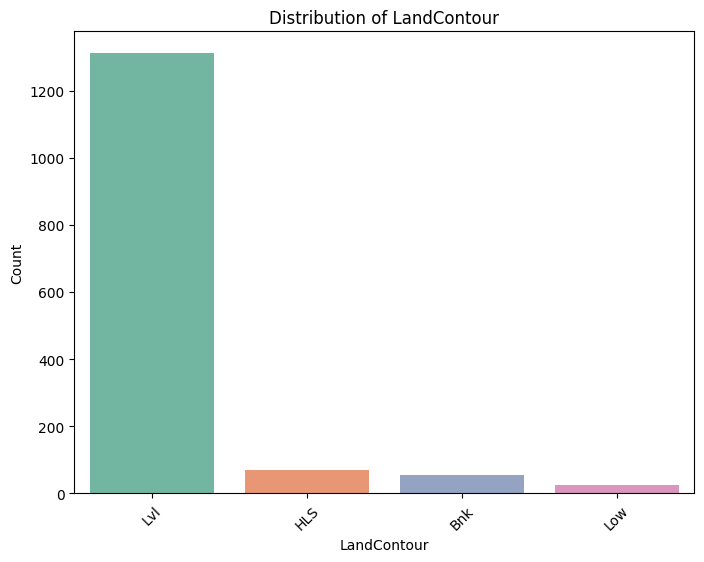

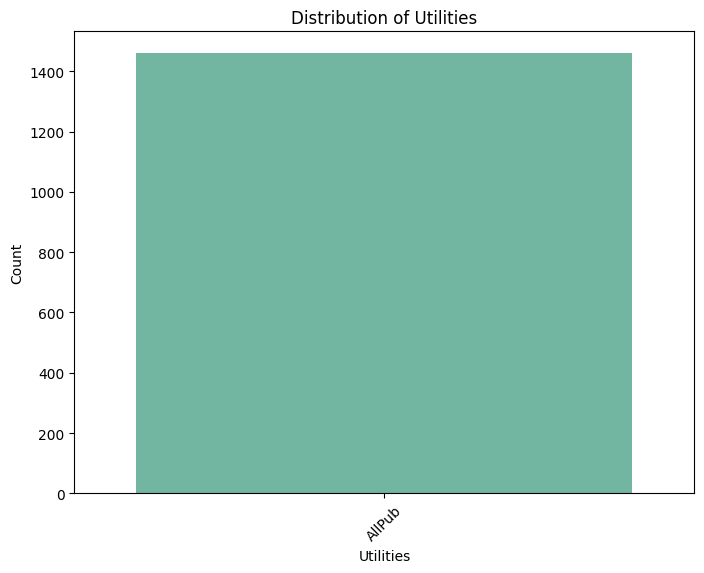

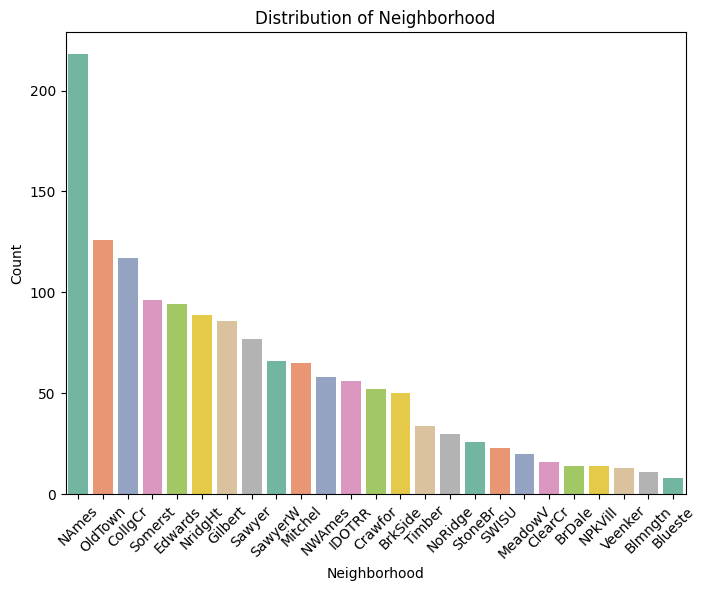

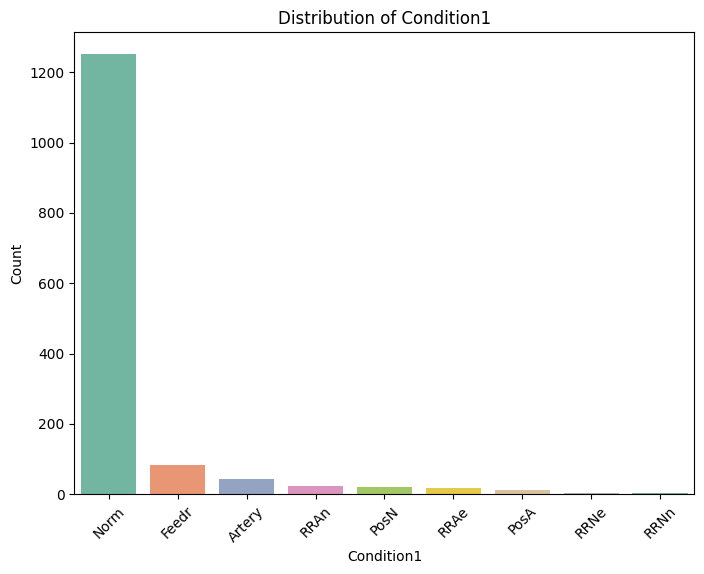

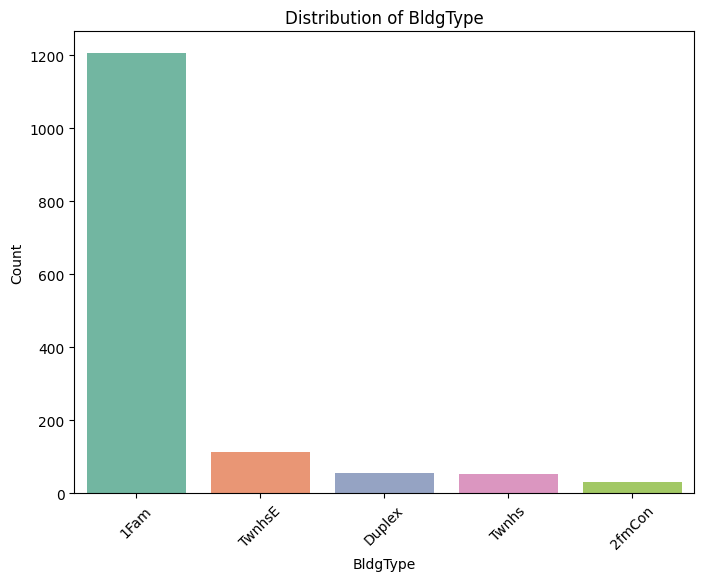

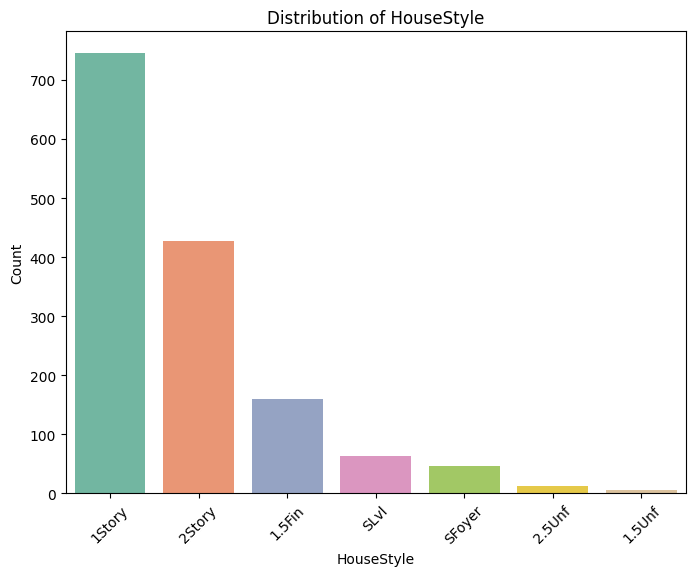

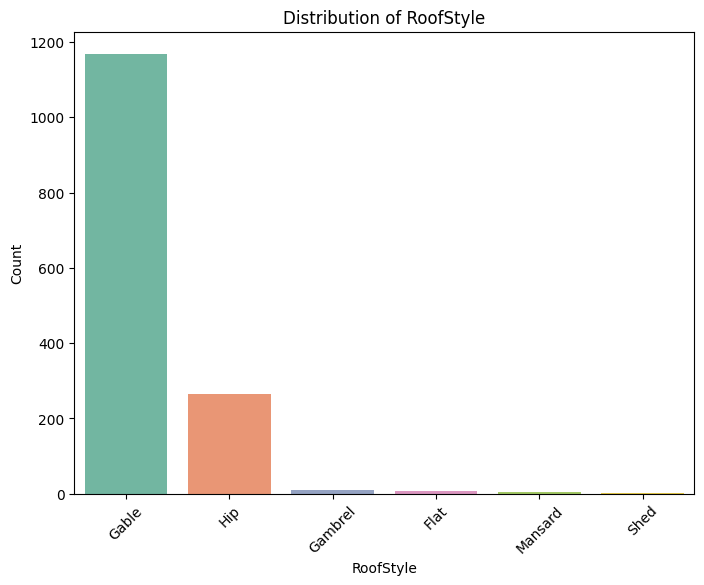

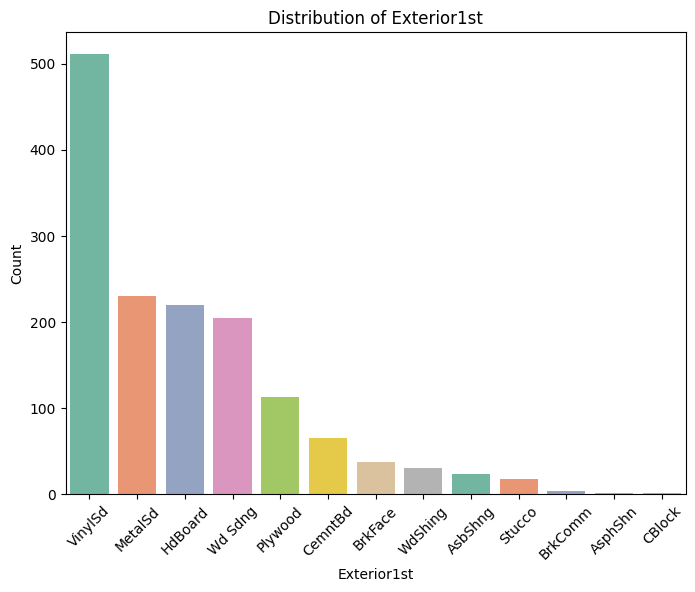

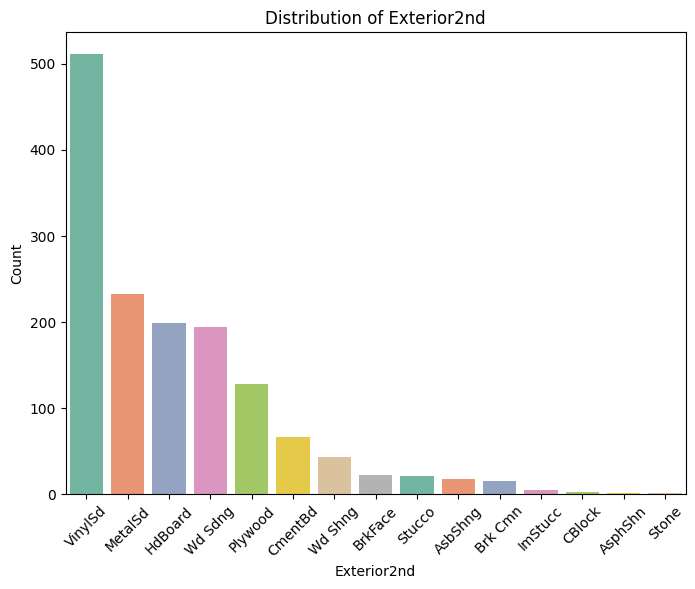

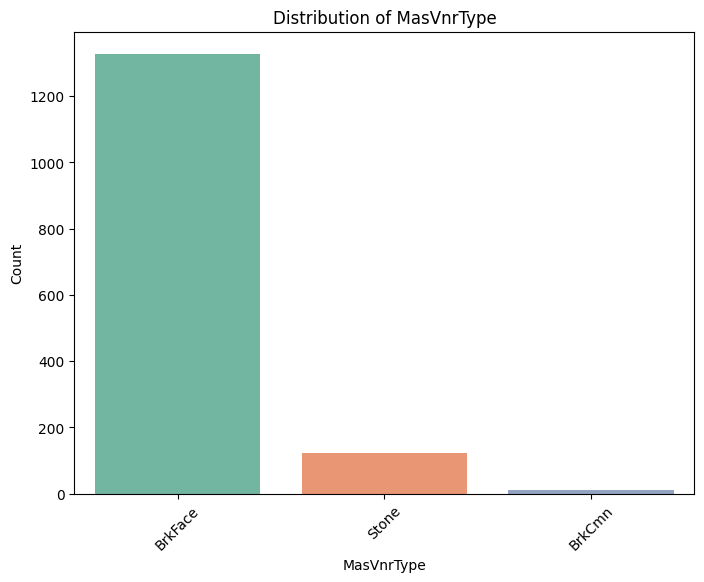

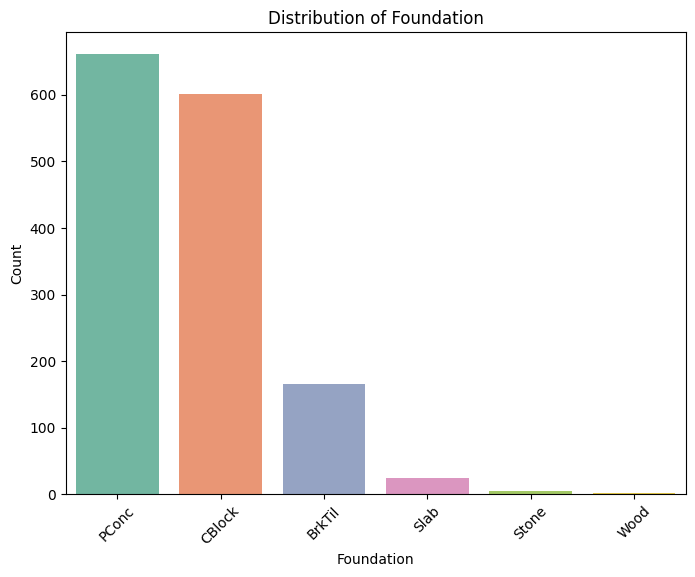

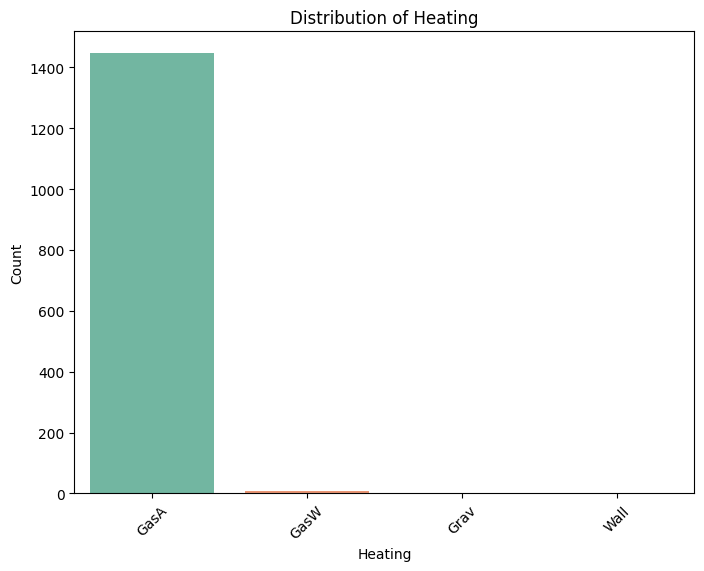

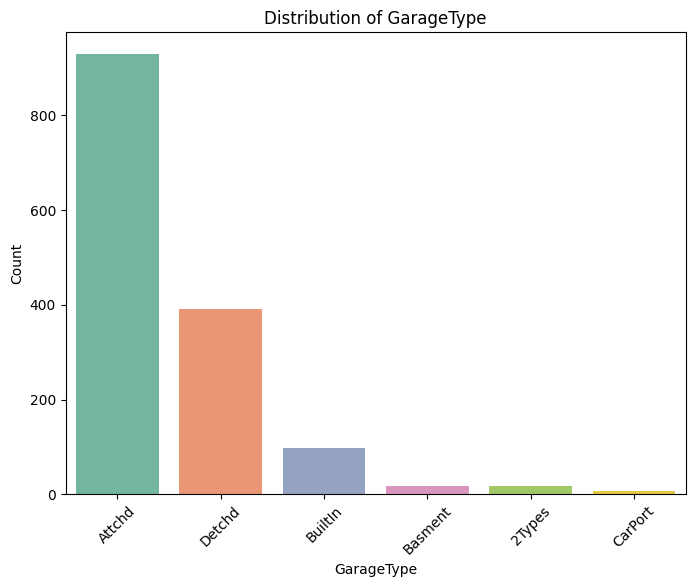

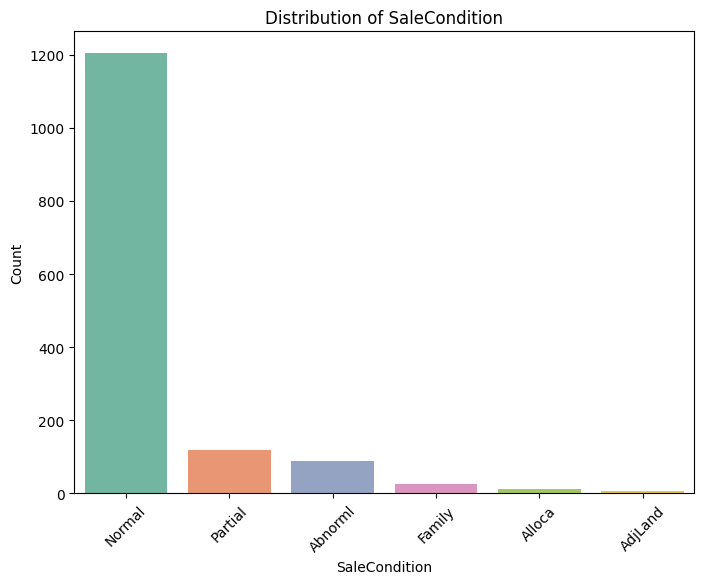

In [21]:

categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
                       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                       'Foundation', 'Heating', 'GarageType', 'SaleCondition']

# Loop through categorical columns and visualize the distribution
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    if col in X_test.columns:  # تحقق من وجود العمود
        sns.countplot(x=X_test[col], order=X_test[col].value_counts().index, palette="Set2")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print(f"Column {col} is not in the DataFrame.")

# 7. Encoding

In [22]:
# Encoding Categorical Variables
label_encoders = {}
for column in categorical_cols:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le


In [23]:
X_train,X_test

(      MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  \
 0           60.0         3         65.0   8450.0       1         3   
 1           20.0         3         80.0   9600.0       1         3   
 2           60.0         3         68.0  11250.0       1         0   
 3           70.0         3         60.0   9550.0       1         0   
 4           60.0         3         84.0  14260.0       1         0   
 ...          ...       ...          ...      ...     ...       ...   
 1455        60.0         3         62.0   7917.0       1         3   
 1456        20.0         3         85.0  13175.0       1         3   
 1457        70.0         3         66.0   9042.0       1         3   
 1458        20.0         3         68.0   9717.0       1         3   
 1459        20.0         3         75.0   9937.0       1         3   
 
       LandContour  Utilities  LotConfig  LandSlope  ...  ScreenPorch  \
 0               3          0          4          0  ...          0.0   


# 8. Standrization 

In [24]:
# Scaling Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
X_train= pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)

X_train.head()


,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.073375,-0.045532,-0.220875,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.313867,0.208502,-1.043259,-0.459303,0.224756
1,-0.872563,-0.045532,0.460320,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,...,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.313867,0.208502,-0.183465,0.466465,0.314624
2,0.073375,-0.045532,-0.084636,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.313867,0.208502,-0.977121,-0.313369,-1.334900
3,0.309859,-0.045532,-0.447940,-0.096897,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,...,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,1.800676,-0.687324,-0.486525
4,0.073375,-0.045532,0.641972,0.375148,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,...,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.313867,0.208502,-0.944052,0.199680,-0.465531


In [26]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-0.872563,-1.628309,0.460320,0.110763,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,...,1.882709,-0.068692,-0.087688,-0.119110,1.64521,0.313867,0.208502,0.411777,-0.400017,1.291404
1,-0.872563,-0.045532,0.505733,0.375850,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,...,-0.270208,-0.068692,25.116309,-0.119110,1.64521,0.313867,0.208502,0.510984,0.619239,0.031186
2,0.073375,-0.045532,0.187842,0.332053,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.270208,-0.068692,-0.087688,-1.229111,1.64521,0.313867,0.208502,-0.778707,-0.295127,-0.952018
3,0.073375,-0.045532,0.369494,-0.054002,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,...,-0.270208,-0.068692,-0.087688,-0.119110,1.64521,0.313867,0.208502,-0.811776,-0.299687,-0.146885
4,1.492282,-0.045532,-1.219961,-0.552407,0.064238,-1.378933,-2.512494,-0.02618,0.604670,-0.225716,...,2.313293,-0.068692,-0.087688,-1.969111,1.64521,0.313867,0.208502,-0.613362,0.507509,-0.688300


# 9.  Feature Selection

In [27]:
# Feature Selection
FeatureSelection = SelectKBest(score_func=f_classif, k=39)
X_train_selected = FeatureSelection.fit_transform(X_train, y_train)
X_test_selected = FeatureSelection.transform(X_test)

selected_features = FeatureSelection.get_support(indices=True)
selected_feature_names = pd.DataFrame(X_train).columns[selected_features]


In [28]:
X_train_selected=pd.DataFrame(X_train_selected)
X_train_selected

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.045532,-0.207142,0.064238,0.750731,-1.206215,-0.03174,0.651479,1.050994,0.878668,-0.255234,...,1.017598,-0.281887,0.311725,0.351000,-0.752176,0.216503,-0.087688,-1.043259,-0.459303,0.224756
1,-0.045532,-0.091886,0.064238,0.750731,1.954302,-0.03174,-0.071836,0.156734,-0.429577,-0.255234,...,-0.107927,-0.281887,0.311725,-0.060731,1.626195,-0.704483,-0.087688,-0.183465,0.466465,0.314624
2,-0.045532,0.073480,0.064238,-1.378933,-1.206215,-0.03174,0.651479,0.984752,0.830215,-0.255234,...,0.934226,-0.281887,0.311725,0.631726,-0.752176,-0.070361,-0.087688,-0.977121,-0.313369,-1.334900
3,-0.045532,-0.096897,0.064238,-1.378933,-1.039872,-0.03174,0.651479,-1.863632,-0.720298,-0.255234,...,0.809167,0.950313,1.650307,0.790804,-0.752176,-0.176048,-0.087688,1.800676,-0.687324,-0.486525
4,-0.045532,0.375148,0.064238,-1.378933,0.457215,-0.03174,1.374795,0.951632,0.733308,-0.255234,...,0.892540,-0.281887,1.650307,1.698485,0.780197,0.563760,-0.087688,-0.944052,0.199680,-0.465531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.045532,-0.260560,0.064238,0.750731,-0.707186,-0.03174,-0.071836,0.918511,0.733308,-0.255234,...,0.850854,-0.281887,0.311725,-0.060731,-0.752176,-0.100558,-0.087688,-0.944052,-0.238122,-0.281622
1456,-0.045532,0.266407,0.064238,0.750731,0.290872,-0.03174,-0.071836,0.222975,0.151865,3.042477,...,-0.024555,0.950313,0.311725,0.126420,2.033231,-0.704483,-0.087688,-0.150396,1.104925,-1.314459
1457,-0.045532,-0.147810,0.064238,0.750731,-1.039872,-0.03174,0.651479,-1.002492,1.024029,-0.255234,...,-1.566941,-0.281887,-1.026858,-1.033914,-0.752176,0.201405,4.953112,1.073157,0.215641,-0.759367
1458,-0.045532,-0.080160,0.064238,0.750731,-0.041814,-0.03174,-0.795151,-0.704406,0.539493,-0.255234,...,-1.191766,0.950313,-1.026858,-1.090059,2.168910,-0.704483,-0.087688,0.775536,0.046905,0.177285


In [29]:
X_test_selected=pd.DataFrame(X_test_selected)
X_test_selected

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-1.628309,0.110763,0.064238,0.750731,-0.041814,-0.03174,-0.795151,-0.340077,-1.156380,-0.255234,...,-0.733219,0.950313,-1.026858,1.202536,0.365179,-0.704483,-0.087688,0.411777,-0.400017,1.291404
1,-0.045532,0.375850,0.064238,-1.378933,-0.041814,-0.03174,-0.071836,-0.439440,-1.301740,-0.255234,...,-0.858277,0.950313,-1.026858,-0.753188,2.384400,-0.160950,25.116309,0.510984,0.619239,0.031186
2,-0.045532,0.332053,0.064238,-1.378933,-0.707186,-0.03174,-0.795151,0.852269,0.636400,-0.255234,...,0.767481,-1.514086,0.311725,0.042202,0.939819,-0.191147,-0.087688,-0.778707,-0.295127,-0.952018
3,-0.045532,-0.054002,0.064238,-1.378933,-0.707186,-0.03174,-0.071836,0.885390,0.636400,-0.255234,...,0.809167,-1.514086,0.311725,-0.013943,2.121024,-0.160950,-0.087688,-0.811776,-0.299687,-0.146885
4,-0.045532,-0.552407,0.064238,-1.378933,1.621616,-0.03174,1.374795,0.686666,0.345679,-0.255234,...,0.559051,-0.281887,0.311725,0.154492,-0.752176,0.533564,-0.087688,-0.613362,0.507509,-0.688300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.537245,-0.859988,0.064238,0.750731,-0.374500,-0.03174,-1.518467,-0.041991,-0.720298,-0.255234,...,0.058817,0.950313,-2.365440,-2.212963,-0.752176,-0.704483,-0.087688,-0.018120,-1.166169,0.106965
1455,1.537245,-0.864197,0.064238,0.750731,-0.374500,-0.03174,-1.518467,-0.041991,-0.720298,-0.255234,...,-0.358044,0.950313,-1.026858,-0.874836,-0.752176,-0.342128,-0.087688,-0.018120,-1.166169,1.189881
1456,-0.045532,0.950423,0.064238,0.750731,-0.208157,-0.03174,-0.795151,-0.373198,0.539493,-0.255234,...,-0.774905,0.950313,0.311725,0.482006,3.030870,-0.704483,-0.087688,0.312570,0.379817,1.455301
1457,-0.045532,-0.007600,0.064238,0.750731,-0.208157,-0.03174,-0.795151,0.686666,0.345679,-0.255234,...,0.058817,0.950313,-2.365440,-2.212963,-0.113687,-0.221343,1.323736,-0.745638,-0.331610,2.007091


# 10. Build the model

In [30]:
# Split Training Data
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

# Train RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)


# 11. Evaluation

In [31]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# Cross-Validation
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"Cross-validated RMSE: {rmse_scores.mean()} ± {rmse_scores.std()}")


RMSE: 27918.154132953685, MAE: 17747.163835616437, R²: 0.8983845915886816
Cross-validated RMSE: 30370.12110340026 ± 5349.255309061342


# 12. Improve the model using XGBoost


In [32]:
# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}, R²: {r2_xgb}")


XGBoost RMSE: 26657.823358762977, R²: 0.9073521090196741


# 13. submission

In [33]:
# Predictions on Test Data
y_test_pred = rf_model.predict(X_test_selected)

# Create Submission File
test_data_original = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.DataFrame({'Id': test_data_original['Id'], 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)
